In [166]:
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score

class MyLinearRegression:
    """
    Parameters
    ----------
    regularization : {None, 'l1', 'l2', 'l1l2'}, default=None
        Какую регуляризацию добавить к модели. Если значение `None`, то без регуляризации.

    weight_calc : {'matrix', 'gd', 'sgd'}, default='matrix'
        Каким образом вычислять вектор весов: матрично ('matrix'), градиентным спуском ('gd') или стохастическим градиентным спуском ('sgd'). При этом, при 'l1' или 'l1l2' нельзя использовать параметр 'matrix'. 

    Attributes
    ----------
    coefs_ : Вектор коэффициентов, размера (1, n+1), где n — количество признаков. n+1 = количество признаков + фиктивная единичная колонка для смещения.

    feature_names_in_ : Массив из n+1 элемента, где первые n элементов — названия соответствующих признаков, а n+1 элемент — 'bias'
    """
    
    def __init__(self, regularization=None, weight_calc='matrix', lambda_1 = None, lambda_2 = None, batch_size=20, learning_rate=0.01, epochs=1000):
        if regularization not in [None, 'l1', 'l2', 'l1l2']:
            raise TypeError(f"Параметр regularization не может принимать значение '{regularization}'")
        if weight_calc not in ['matrix', 'gd', 'sgd']:
            raise TypeError(f"Параметр weight_calc не может принимать значение '{weight_calc}'")
        if regularization in ['l1', 'l1l2'] and lambda_1 is None:
            raise TypeError(f"Значение коэффициента регулризации l1 не задано")
        if regularization in ['l2', 'l1l2'] and lambda_2 is None:
            raise TypeError(f"Значение коэффициента регулризации l2 не задано")
        
        self.regularization = regularization
        self.weight_calc = weight_calc
        self.lambda_1 = lambda_1
        self.lambda_2 = lambda_2
        self.batch_size = batch_size
        self.feature_names_in = None
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.loss_array = None

    def regularize(self, gradients, w):
        if self.regularization == 'l1':
            gradients[1:] += self.lambda_1 * np.sign(w[1:]) # знаковая функция, -1 если значение отриц., 1, если положительное
        elif self.regularization == 'l2':
            gradients[1:] += 2 * self.lambda_2 * w[1:]
        elif self.regularization == 'l1l2':
            gradients[1:] += self.lambda_1 * np.sign(w[1:]) + 2 * self.lambda_2 * w[1:]
        return gradients

    def _mean_squared_error(self, X, y, w): # Функции для наглядности, почему-то не работают как надо при вызове в цикле
        y_pred = np.dot(X, w)
        mse = np.mean((y_pred - y)**2)
    
        return mse
    
    def mean_squared_error_gradient(self, w, X, y): # Функции для наглядности, почему-то не работают как надо при вызове в цикле
        y_pred = np.dot(X, w)
        gradient = -2 * np.dot(X.T, (y - y_pred)) / len(y)
    
        return gradient
    
    def _matrix_weight_calc(self, X, y):
        if self.regularization in ['l1', 'l1l2']:
            raise TypeError(f'Регуляризацию {self.regularization} невозможно использовать при вычислении весов матричным методом')
        if self.regularization == 'l2':
            n = X.shape[1] - 1  # количество признаков
            identity_matrix = np.eye(n + 1)  # единичная матрица
            identity_matrix[0, 0] = 0  # не применять регуляризацию к смещению (bias)
            return np.linalg.inv(X.T @ X + 2 * self.lambda_2 * identity_matrix) @ X.T @ y  # матричный метод с L2-регуляризацией
        if self.regularization is None:
            return np.linalg.inv(X.T @ X) @ X.T @ y # матричный метод

    def _gd_weight_calc(self, X, y):
        w_init = np.ones(X.shape[1])
        print(f'w_init: {w_init}')
        w = w_init
        loss_array = []

        for _ in range(self.epochs):
            gradient = -2 * np.dot(X.T, (y - np.dot(X, w))) / len(y) # mse gradient
            if self.regularization is not None:
                gradient = self.regularize(gradient, w) # регуляризация
            w = w - self.learning_rate * gradient
            current_loss = np.mean((np.dot(X, w) - y)**2) # mse
            loss_array.append(current_loss)
            #print(f"Iteration {_ + 1}/{self.epochs}, Loss: {current_loss}")
        return w, loss_array
    

    def _sgd_weight_calc(self, X, y):
        w_init = np.ones(X.shape[1])
        w = w_init
        loss_array = []

        for _ in range(self.epochs):
            for i in range(0, X.shape[0], self.batch_size):
                X_batch = X[i:i + self.batch_size]
                y_batch = y[i:i + self.batch_size]
                gradient = -2 * np.dot(X_batch.T, (y_batch - np.dot(X_batch, w))) / len(y_batch) # mse gradient
                if self.regularization is not None:
                    gradient = self.regularize(gradient, w) # регуляризация
                w = w - self.learning_rate * gradient

            current_loss = np.mean((np.dot(X, w) - y)**2)
            loss_array.append(current_loss)
            #print(f"Epoch {_ + 1}/{self.epochs}, Loss: {current_loss}")

        return w, loss_array
        
    def fit(self, X: pd.DataFrame, y: pd.DataFrame):
        X_new = np.c_[np.ones(X.shape[0]), X]
        self.feature_names_in = np.append('bias', X.columns)
        if self.weight_calc == 'matrix':
            self.coef_ = self._matrix_weight_calc(X_new, y)
        if self.weight_calc == 'gd':
            self.coef_, self.loss_array = self._gd_weight_calc(X_new, y)
        if self.weight_calc == 'sgd':
            self.coef_, self.loss_array = self._sgd_weight_calc(X_new, y)

    def predict(self, X: np.array, ss=True):
        X_new = np.c_[np.ones(X.shape[0]), X]
        predictions = X_new @ self.coef_
        return predictions
    
    def score(self, X: np.array, y: np.array):
        y_predicted = self.predict(X)
        r2 = r2_score(y, y_predicted)
        print(pd.DataFrame(self.coef_, index=self.feature_names_in))
        print(f'R2 score: {r2}')
        return r2

In [87]:
X[10:10+20]

,engine_power,age_in_days,km,previous_owners
10,69,3500,121000,2
11,69,3197,51083,2
12,69,2251,87000,2
13,69,3774,79000,1
14,69,4018,101156,1
15,69,2922,31350,1
16,69,2588,71553,1
17,69,2647,50000,2
18,99,3592,74903,1
19,69,2922,87000,2


In [61]:
lr_2.mean_squared_error_gradient(w, X_new, y)

array([1.99400774e+05, 1.47648234e+07, 7.71521025e+08, 2.50665171e+10,
       3.05423174e+05])

In [59]:
X_new = np.c_[np.ones(X.shape[0]), X]
w_init = np.ones(X_new.shape[1])
w = w_init
np.mean((np.dot(X_new, w) - y)**2)

12427086628.265789

In [52]:
X @ np.ones(X.shape[1])

0       61324.0
1      162778.0
2      173541.0
3      135359.0
4      128273.0
         ...   
375     60521.0
376    138987.0
377    116884.0
378    133782.0
379    100666.0
Length: 380, dtype: float64

In [39]:
np.linalg.inv(X.T @ X) @ X.T @ y

0    124.167699
1     -1.085423
2     -0.009235
3    784.588631
dtype: float64

In [162]:
print(pd.DataFrame(lr_1.coef_, index=lr_1.feature_names_in))

                           0
bias             5864.786184
engine_power       58.166370
age_in_days     -1628.088457
km               -430.979804
previous_owners    21.617023


In [ ]:
w_init = np.array([1.0, 1.0, 1.0])

X_new = np.c_[np.ones(n), X]

In [ ]:
def log_loss(w, X, y):
  return np.sum(np.log(1+np.exp(-y*np.dot(X,w))))

In [ ]:
def log_loss_grad(w, X, y):
  gradient = - np.dot(y*X.T, 1/(1+np.exp(y*np.dot(X,w))))
  return gradient/np.linalg.norm(gradient)

In [ ]:
def gradient_descent(X, y, w_init, n_steps, eta):

  w = w_init
  loss_array = []

  for step in range(n_steps):
    gradient = log_loss_grad(w, X, y)
    w = w - eta * gradient
    current_loss = log_loss(w, X, y)
    loss_array.append(current_loss)
    print(f"Iteration {step + 1}/{n_steps}, Loss: {current_loss}")

  return w, loss_array

In [2]:
df = pd.read_csv('Used_fiat_500_in_Italy_dataset.csv')

In [5]:
from sklearn.model_selection import train_test_split

dfnum = df.select_dtypes(include=np.number)
dfnum.drop(['lat','lon'], axis=1, inplace=True)
dfnum
X = dfnum.drop('price', axis=1)
y = dfnum['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [167]:
lr_1 = MyLinearRegression()

lr_1.fit(X_train, y_train)
lr_1.score(X_test, y_test)

                           0
bias             5864.786184
engine_power       58.166370
age_in_days     -1628.088457
km               -430.979804
previous_owners    21.617023
R2 score: 0.7594567271465461


0.7594567271465461

In [179]:
lr_12 = MyLinearRegression(regularization='l2', lambda_2=0.0001)

lr_12.fit(X_train, y_train)
lr_12.score(X_test, y_test)

                           0
bias             5864.786184
engine_power       58.166047
age_in_days     -1628.086437
km               -430.980967
previous_owners    21.617093
R2 score: 0.759456740725748


0.759456740725748

In [48]:
np.ones(X.shape[1])

array([1., 1., 1., 1.])

In [138]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns)

In [168]:
lr_2 = MyLinearRegression(weight_calc='gd')

lr_2.fit(X_train, y_train)
lr_2.score(X_test, y_test)

w_init: [1. 1. 1. 1. 1.]
                           0
bias             5864.786174
engine_power       57.817892
age_in_days     -1623.953400
km               -435.024986
previous_owners    21.978609
R2 score: 0.759562622769302


0.759562622769302

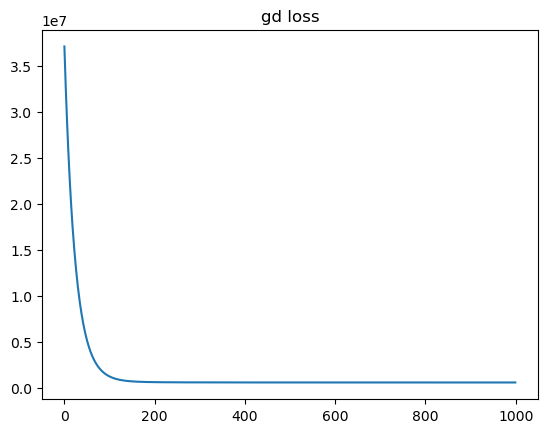

In [140]:
import matplotlib.pyplot as plt

plt.plot(lr_2.loss_array)
plt.title('gd loss')
plt.show()

In [170]:
lr_3 = MyLinearRegression(weight_calc='sgd')

lr_3.fit(X_train, y_train)
lr_3.score(X_test, y_test)

                           0
bias             5858.448469
engine_power       73.294431
age_in_days     -1678.223983
km               -407.825874
previous_owners    18.176084
R2 score: 0.7588418732350536


0.7588418732350536

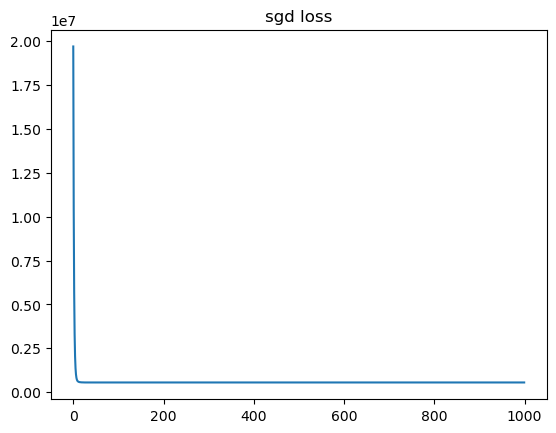

In [127]:
import matplotlib.pyplot as plt

plt.plot(lr_3.loss_array)
plt.title('sgd loss')
plt.show()

In [171]:
lr_4 = MyLinearRegression(weight_calc='sgd', regularization='l1', lambda_1=0.1)

lr_4.fit(X_train, y_train)
lr_4.score(X_test, y_test)

                           0
bias             5858.449399
engine_power       73.224582
age_in_days     -1678.187470
km               -407.787574
previous_owners    18.124875
R2 score: 0.7588427876585562


0.7588427876585562

In [145]:
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score

lasso_fake = Lasso(alpha=0.1).fit(X_train, y_train)
y_pred = lasso_fake.predict(X_test)
r2_score(y_test, y_pred)

0.7594540891114422

In [146]:
lasso_fake.coef_

array([   58.0701342 , -1628.18868756,  -430.77884785,    21.50532953])

In [147]:
lr_5 = MyLinearRegression(weight_calc='sgd', regularization='l2', lambda_2=0.01)

lr_5.fit(X_train, y_train)
lr_5.score(X_test, y_test)

R2 score: 0.7592494494185733


0.7592494494185733

In [148]:
lr_5.coef_

array([ 5857.99475662,    68.42818611, -1647.32075262,  -426.08750511,
          19.26195086])

In [149]:
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score

ridge_fake = Ridge(alpha=0.01).fit(X_train, y_train)
y_pred = ridge_fake.predict(X_test)
r2_score(y_test, y_pred)

0.7594574050449694

In [150]:
ridge_fake.coef_

array([   58.15020858, -1627.98747095,  -431.03795108,    21.62048099])

In [152]:
lr_6 = MyLinearRegression(weight_calc='sgd', regularization='l1l2', lambda_1=0.01, lambda_2=0.01)

lr_6.fit(X_train, y_train)
lr_6.score(X_test, y_test)

R2 score: 0.7592495042348671


0.7592495042348671

In [154]:
from sklearn.linear_model import ElasticNet

elastic = ElasticNet(alpha=0.01, l1_ratio=1.0).fit(X_train, y_train)
y_pred = elastic.predict(X_test)
r2_score(y_test, y_pred)

0.7594562607954051

In [24]:
lr_1.coef_

array([ 1.01050994e+04,  5.71347854e+00, -1.14397982e+00, -9.11044908e-03,
        3.92958362e+01])

In [25]:
lr_1.feature_names_in

array(['bias', 'engine_power', 'age_in_days', 'km', 'previous_owners'],
      dtype=object)

In [26]:
X_new = np.c_[np.ones(X.shape[0]), X]

In [27]:
X_new

array([[1.00000e+00, 6.90000e+01, 4.47400e+03, 5.67790e+04, 2.00000e+00],
       [1.00000e+00, 6.90000e+01, 2.70800e+03, 1.60000e+05, 1.00000e+00],
       [1.00000e+00, 6.90000e+01, 3.47000e+03, 1.70000e+05, 2.00000e+00],
       ...,
       [1.00000e+00, 6.90000e+01, 3.47000e+03, 1.13344e+05, 1.00000e+00],
       [1.00000e+00, 6.90000e+01, 3.71200e+03, 1.30000e+05, 1.00000e+00],
       [1.00000e+00, 9.90000e+01, 4.56600e+03, 9.60000e+04, 1.00000e+00]])

In [28]:
lr_1.predict(X_test)

array([ 4425.05136895,  5501.51990093,  4496.68167534,  4501.09054717,
        9614.18028237,  5471.62734656,  4039.75048943,  4528.42189441,
        4994.18879237,  4506.57760614,  5376.71685777,  5130.84552857,
        4202.51336727,  4403.83907187,  9826.18850768,  5199.12614308,
        7131.99579688,  4117.87319121,  4823.21266157, 10044.341679  ,
       10152.0582216 ,  4962.95336861,  6290.50979353,  9917.24086796,
        4696.46912919,  8757.32169406,  4744.31944346,  4345.49015006,
        9505.59634434,  5277.26362822,  4117.87319121,  8812.16693045,
        4298.92230915,  4704.62125052,  9314.05916688,  3917.44331146,
        4578.68134043,  4696.46912919,  4816.80067937,  5608.05488741,
        5338.38559465,  9618.16178225,  8709.25510045,  4342.02537715,
        9164.66745387,  5189.53270655,  6084.26231003,  4346.21291281,
        6008.21019744,  6815.58176227,  4800.88421973,  4609.19073053,
        5005.36197895,  4167.96721021,  4390.97875804,  4423.33533361,
      